In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Patch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib
import pandas as pd
import pathlib
import math

from utils import model_shortname

# remove limits for rows and cols in dataframe listing
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

Using TensorFlow backend.


# Input

In [2]:
# loading predictions from feather file (processed in another notebook)
p = pathlib.Path("./predictions_all_info.feather")
if p.is_file():
    df = pd.read_feather(p)
else:
    df = pd.DataFrame()

array(['/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_S',
       '/misc/users/tiagonb/covid-net/tools/experiments/mlruns/6/a2e0cca363864022bb95d29362abea83/artifacts/model/data/model.h5',
       '/misc/users/tiagonb/covid-net/tools/experiments/mlruns/6/da94eba6fec04c908d77f33ea7f1f405/artifacts/model/data/model.h5',
       '/misc/users/tiagonb/covid-net/tools/experiments/mlruns/6/3728ffeddd1e44b8a8909421793a6d88/artifacts/model/data/model.h5',
       '/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L'],
      dtype=object)

# Métricas classificadoras

In [3]:
def classify_valid_threshold(df, threshold=0.5, lung_part=None):
    if lung_part is not None:
        df = df[df['pred_lungclass'] == lung_part]
    new_df = df.sort_values(
        by=['files'], ascending=True).reset_index(drop=True)
    values = new_df['prob_NCP']
    slices = values.gt(threshold)
    if slices.any():
        return 'NCP'
    values = new_df['prob_CP']
    slices = values.gt(threshold)
    if slices.any():
        return 'CP'
    return 'Normal'


def classify_valid_block(df, threshold=0.5, shift=1, lung_part=None):
    if lung_part is not None:
        df = df[df['pred_lungclass'] == lung_part]
    new_df = df.sort_values(
        by=['files'], ascending=True).reset_index(drop=True)
    values = new_df['prob_NCP']
    values_cut = values.gt(threshold)
    if shift == 2:
        slices = values_cut & values_cut.shift(
            1) & values_cut.shift(-1) & values_cut.shift(2) & values_cut.shift(-2)
    elif shift == 3:
        slices = values_cut & values_cut.shift(1) & values_cut.shift(-1) & values_cut.shift(
            2) & values_cut.shift(-2) & values_cut.shift(3) & values_cut.shift(-3)
    else:
        slices = values_cut & values_cut.shift(1) & values_cut.shift(-1)
    slices.fillna(False, inplace=True)
    if slices.any():
        return 'NCP'
    values = new_df['prob_CP']
    values_cut = values.gt(threshold)
    if shift == 2:
        slices = values_cut & values_cut.shift(
            1) & values_cut.shift(-1) & values_cut.shift(2) & values_cut.shift(-2)
    elif shift == 3:
        slices = values_cut & values_cut.shift(1) & values_cut.shift(-1) & values_cut.shift(
            2) & values_cut.shift(-2) & values_cut.shift(3) & values_cut.shift(-3)
    else:
        slices = values_cut & values_cut.shift(1) & values_cut.shift(-1)
    slices.fillna(False, inplace=True)
    if slices.any():
        return 'CP'
    return 'Normal'


def classify_sum_percentage(df, threshold=0.5, lung_part=None):
    if lung_part is not None:
        df = df[df['pred_lungclass'] == lung_part]
    sum_ncp = df['prob_NCP'].sum()
    sum_cp = df['prob_CP'].sum()
    sum_normal = df['prob_Normal'].sum()
    total = sum_ncp + sum_cp + sum_normal
    if (sum_ncp + sum_cp) / total > threshold:
        if sum_ncp >= sum_cp:
            return 'NCP'
        else:
            return 'CP'
    return 'Normal'


def classify_small_entropy_slices(df, threshold=0.5, lung_part=None):
    if lung_part is not None:
        df = df[df['pred_lungclass'] == lung_part]
    new_df = df
    values = -(((new_df['prob_NCP']*np.log2(new_df['prob_NCP'])) +
               (new_df['prob_CP']*np.log2(new_df['prob_CP'])) +
               (new_df['prob_Normal']*np.log2(new_df['prob_Normal']))) / np.log2(3))
    values_cut = values.lt(0.3)
    sum_ncp = (df['prob_NCP'] * values_cut.astype(int)).sum()
    sum_cp = (df['prob_CP'] * values_cut.astype(int)).sum()
    sum_normal = (df['prob_Normal'] * values_cut.astype(int)).sum()
    total = sum_ncp + sum_cp + sum_normal
    if sum_ncp / total > threshold:
        return 'NCP'
    if sum_cp / total > threshold:
        return 'CP'
    return 'Normal'

# Visualização

In [3]:
def metric_valid_threshold(df):
    thres = 0.5
    new_df = df.sort_values(by=['files'], ascending=True).reset_index(drop=True)
    values = new_df['prob_NCP']
    slices = values.gt(thres)
    #values_cut = values.gt(thres)
    #slices = values_cut & values_cut.shift(1) & values_cut.shift(-1)
    
    return slices
    
def metric_valid_block(df):
    thres = 0.5
    new_df = df.sort_values(by=['files'], ascending=True).reset_index(drop=True)
    values = new_df['prob_NCP']
    values_cut = values.gt(0.1)
    slices = values_cut & values_cut.shift(1) & values_cut.shift(-1)
    slices.fillna(False, inplace=True)
    #slices = values_blocked & values.gt(thres)
    
    return slices

def metric_valid_entropy(df):
    thres = 0.5
    new_df = df.sort_values(by=['files'], ascending=True).reset_index(drop=True)
    values = -(((new_df['prob_NCP']*np.log2(new_df['prob_NCP'])) + 
               (new_df['prob_CP']*np.log2(new_df['prob_CP'])) +
               (new_df['prob_Normal']*np.log2(new_df['prob_Normal']))) / np.log2(3))
    values_cut = values.lt(0.3)
    slices = values_cut
#     values_cut = values.gt(0.1)
#     slices = values_cut & values_cut.shift(1) & values_cut.shift(-1)
#     slices.fillna(False, inplace=True)
    #slices = values_blocked & values.gt(thres)
    
    return slices





def make_panel_with_metrics(df, metrics, figtitle=None, savefig=None, model_shortname={}):
    #defining number of columns and rows in the matplotlib fig, each graph ocupy 3 columns
    n = len(metrics)
    num_columns = 12
    columns_for_graph = 2
    num_rows = math.ceil(n / (num_columns // columns_for_graph))
    print('n={}, cols={}, rows={}'.format(n, num_columns, num_rows))
    fig = plt.figure(constrained_layout=True, figsize=(num_columns, num_rows*4))
    spec = fig.add_gridspec(num_rows, num_columns)
    if figtitle:
        fig.suptitle(figtitle)

    #first graph exam slices
    axs = []
    ax1 = fig.add_subplot(spec[0, 0:2])
    ax2 = fig.add_subplot(spec[0, 2:3])
    axs.append((ax1, ax2))
    
    model_data = df.sort_values(by=['files'], ascending=True).reset_index(drop=True)
    len_data = len(model_data.index)
    model_data['pred_dummy'] = [0.33] * len_data
    model_data['lesion_dummy'] = [0.33] * len_data
    model_data['cluster_dummy'] = [0.33] * len_data

    classes_order = (['NCP'] * len_data) + (['CP'] * len_data) + (['Normal'] * len_data)

    #add width=1.0 to remove space between bars
    barplot1 = model_data[['prob_NCP', 'prob_CP', 'prob_Normal']].plot(kind='barh', 
                                                                            stacked=True, 
                                                                            legend=False, 
                                                                            ax=ax1, width=1.0)
    #change patches colors
    children1=barplot1.get_children()
    barlist1=filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), children1)
    for c, bar in zip(classes_order, barlist1):
        if c == "CP": 
            bar.set_color('blue')
        elif c == "NCP":
            bar.set_color('red')
        else:
            bar.set_color('green')

    #concatenate values in one big vector to help set the correct color afterward
    data_type = ([0]*len_data) + ([1]*len_data) + ([2]*len_data)
    pred_n_lessions = pd.concat([model_data['pred_class'], 
                                 model_data['has_lesion'],
                                 model_data['pred_lungclass']]).reset_index(drop=True)

    #add width=1.0 to remove space between bars
    barplot2 = model_data[['pred_dummy', 'lesion_dummy', 'cluster_dummy']].plot(kind='barh', 
                                                               stacked=True, 
                                                               legend=False, 
                                                               ax=ax2, width=1.0)
    #change patches colors
    children2=barplot2.get_children()
    barlist2=filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), children2)
    for c, dt, bar in zip(pred_n_lessions, data_type, barlist2):
        if dt == 0:
            if c == "CP": 
                bar.set_color('blue')
            elif c == "NCP":
                bar.set_color('red')
            else:
                bar.set_color('green')
        elif dt == 1:
            if c:
                bar.set_color('black')
            else:
                bar.set_color('white')
        else:
            if c == "superior_lung":
                bar.set_color('magenta')
            elif c == "middle_lung":
                bar.set_color('yellow')
            elif c == "inferior_lung":
                bar.set_color('cyan')
            else:
                bar.set_color('black')

    #adjusting graph 
    ax1.set_xlabel("prob(%)")
    ax1.set_ylabel("ct slice")
    ax1.set_ylim(0, len_data)
    ax1.invert_yaxis()
    ax1.set_xlim(0.0, 1)
    try:
        short_name = model_shortname[model_data['model'].values[0] ]
    except:
        short_name = "no name"
    ax1.set_title(short_name)
    ax1.yaxis.set_major_locator(plticker.MaxNLocator(integer=True))
    ax1.yaxis.set_major_formatter(plticker.ScalarFormatter())
    ax2.set_xticks([], [])
    ax2.set_yticks([], [])
    ax2.invert_yaxis()
    ax2.set_title("prediction")
    
    for g in range(2, n+2):
        floor_div = g // (num_columns // columns_for_graph)
        re_div = g % (num_columns // columns_for_graph)
        i, j = floor_div, re_div * columns_for_graph
        print(g, i, j)
        ax1 = fig.add_subplot(spec[i, (j):(j+2)])
        axs.append((ax1, None))

    #iterate in each model
    for i, (metric, title) in enumerate(metrics, start = 1):
        len_data = len(metric)

        #recover previus created axes
        ax = axs[i]
        ax1, ax2 = ax[0], ax[1]

        classes_order = (['NCP'] * len_data) + (['CP'] * len_data) + (['Normal'] * len_data)

        model_data['filtered_prob_NCP'] = model_data['prob_NCP'] * metric.astype(int)
        model_data['filtered_prob_CP'] = model_data['prob_CP'] * metric.astype(int)
        model_data['filtered_prob_Normal'] = model_data['prob_Normal'] * metric.astype(int)
        barplot1 = model_data[['filtered_prob_NCP', 'filtered_prob_CP', 'filtered_prob_Normal']].plot(kind='barh', 
                                                                                stacked=True, 
                                                                                legend=False, 
                                                                                ax=ax1, width=1.0)
        #change patches colors
        children1=barplot1.get_children()
        barlist1=filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), children1)
        for c, bar in zip(classes_order, barlist1):
            if c == "CP": 
                bar.set_color('blue')
            elif c == "NCP":
                bar.set_color('red')
            else:
                bar.set_color('green')

        #adjusting graph 
        ax1.set_xlabel("valid slices")
        #ax1.set_ylabel("ct slice")
        ax1.set_ylim(0, len_data)
        ax1.invert_yaxis()
        ax1.set_xlim(0.0, 1)
        ax1.set_title(title)
        ax1.yaxis.set_major_locator(plticker.MaxNLocator(integer=True))
        ax1.yaxis.set_major_formatter(plticker.ScalarFormatter())

    #custom legend for the graph
    legend_elements1 = [Patch(facecolor='blue', label='CP'),
                       Patch(facecolor='red', label='NCP'),
                       Patch(facecolor='green', label='Normal'),
                       Patch(facecolor='black', label='Lesion')]
    fig.legend(handles=legend_elements1, loc='upper left',
                      title="Predictions", bbox_to_anchor=(0.85,0.35))
    legend_elements2 = [Patch(facecolor='magenta', label='Superior'),
                       Patch(facecolor='yellow', label='Middle'),
                       Patch(facecolor='cyan', label='Inferior')]
    fig.legend(handles=legend_elements2, loc='upper left',
                      title="Lung Areas", bbox_to_anchor=(0.85,0.2))

    if savefig:
        plt.show()
        plt.savefig(savefig, facecolor='white', transparent=False)

# processamento

In [7]:
# model_name='/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_S'
# dataset_name='/misc/users/tiagonb/covid-net/dataset/NCP/61/1255'

#df = df[(df['model'] == model_name) & (df['dataset'] == dataset_name)]

#models = ['/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L','/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_S']
model_name = '/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L'
new_df = df[(df['model'] == model_name)]
new_df = new_df.sort_values(
    by=['files'], ascending=True).reset_index(drop=True)

In [7]:
df['model'].unique()

array(['/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_S',
       '/misc/users/tiagonb/covid-net/tools/experiments/mlruns/6/a2e0cca363864022bb95d29362abea83/artifacts/model/data/model.h5',
       '/misc/users/tiagonb/covid-net/tools/experiments/mlruns/6/da94eba6fec04c908d77f33ea7f1f405/artifacts/model/data/model.h5',
       '/misc/users/tiagonb/covid-net/tools/experiments/mlruns/6/3728ffeddd1e44b8a8909421793a6d88/artifacts/model/data/model.h5',
       '/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L'],
      dtype=object)

In [ ]:
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix


def metric_to_df(df, model_name, metric_name, prediction, observation, threshold=0.5):
    result = [model_name, metric_name, threshold]
    acc_score = accuracy_score(observation, prediction)
    result.extend([acc_score])
    cnf_matrix = multilabel_confusion_matrix(
        observation, prediction, labels=['NCP', 'CP', 'Normal'])
    result.extend(cnf_matrix.ravel())

    series = pd.Series(result, index=df.columns)
    df = df.append(series, ignore_index=True)

    return df


# dataframe to store metrics evaluation results
metrics_df = pd.DataFrame(columns=["model_name", "metric", "threshold", "acc_score",
                                   "tn_ncp", "fp_ncp", "fn_ncp", "tp_ncp",
                                   "tn_cp", "fp_cp", "fn_cp", "tp_cp",
                                   "tn_normal", "fp_normal", "fn_normal", "tp_normal"
                                   ])

models = ['/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L',
          '/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_S']
for model_name in models:
    new_df = df[(df['model'] == model_name)]
    for t in np.arange(0.0, 1.0, 0.01):
        counter = 0
        labels = []
        block_result1, block_result2, block_result3 = [], [], []
        threshold_result = []
        sum_percent_result = []
        small_entropy_result = []
        block_midllelung_result1, block_midllelung_result2, block_midllelung_result3 = [], [], []
        threshold_midllelung_result = []
        sum_percent_midllelung_result = []
        small_entropy_midllelung_result = []
        # loop throught all exams, each exam (g) contains # slices
        print("####### ", t)
        for i, ((d, l, s), g) in enumerate(new_df.groupby(['dataset', 'label', 'new_split_class'])):
            if s == 'train':
                counter += 1
                print("model:{}, counter:{}".format(model_name, counter))
                #print("dataset={}, label={}, split_class={}, dataframe={}".format(d, l, s, g.shape))
                # labels store exam truth condition (NCP, CP, Normal)
                labels.append(l)
                # metrics calculation for each exam
                res11 = classify_valid_block(g, threshold=t, shift=1)
                res12 = classify_valid_block(g, threshold=t, shift=2)
                res13 = classify_valid_block(g, threshold=t, shift=3)
                res2 = classify_valid_threshold(g, threshold=t)
                res3 = classify_sum_percentage(g, threshold=t)
                res4 = classify_small_entropy_slices(g, threshold=t)
                res51 = classify_valid_block(
                    g, threshold=t, shift=1, lung_part='middle_lung')
                res52 = classify_valid_block(
                    g, threshold=t, shift=2, lung_part='middle_lung')
                res53 = classify_valid_block(
                    g, threshold=t, shift=3, lung_part='middle_lung')
                res6 = classify_valid_threshold(
                    g, threshold=t, lung_part='middle_lung')
                res7 = classify_sum_percentage(
                    g, threshold=t, lung_part='middle_lung')
                res8 = classify_small_entropy_slices(
                    g, threshold=t, lung_part='middle_lung')
                # storing results
                block_result1.append(res11)
                block_result2.append(res12)
                block_result3.append(res13)
                threshold_result.append(res2)
                sum_percent_result.append(res3)
                small_entropy_result.append(res4)
                block_midllelung_result1.append(res51)
                block_midllelung_result2.append(res52)
                block_midllelung_result3.append(res53)
                threshold_midllelung_result.append(res6)
                sum_percent_midllelung_result.append(res7)
                small_entropy_midllelung_result.append(res8)

        results = [('bloco (shift 1)', block_result1),
                   ('bloco (shift 2)', block_result2),
                   ('bloco (shift 3)', block_result3),
                   ('threshold', threshold_result),
                   ('soma', sum_percent_result),
                   ('soma entropia', small_entropy_result),
                   ('bloco (mid - sft 1)', block_midllelung_result1),
                   ('bloco (mid - sft 2)', block_midllelung_result2),
                   ('bloco (mid - sft 3)', block_midllelung_result3),
                   ('threshold (mid)', threshold_midllelung_result),
                   ('soma (mid)', sum_percent_midllelung_result),
                   ('soma entropia (mid)', small_entropy_midllelung_result)
                   ]
        for name, result in results:
            metrics_df = metric_to_df(
                metrics_df, model_name, name, result, labels, threshold=t)

In [50]:
from sklearn.dummy import DummyClassifier

# classificador dummy uniforme
dummy_uni = DummyClassifier(strategy="uniform")
dummy_uni.fit(labels, labels)
dummy_uni_pred = dummy_uni.predict(labels)

# classificador dummy mais frequente
dummy_most = DummyClassifier(strategy="most_frequent")
dummy_most.fit(labels, labels)
dummy_most_pred = dummy_most.predict(labels)

# classificador dummy distribuição de entrada
dummy_strat = DummyClassifier(strategy="stratified")
dummy_strat.fit(labels, labels)
dummy_strat_pred = dummy_strat.predict(labels)

NameError: name 'labels' is not defined

# ploting metrics

In [2]:
# metrics_df.to_feather("./metrics_df.feather")
metrics_df = pd.read_feather("./metrics_df.feather")
# !rm metrics_df.feather
!ls - lh * .feather

-rw-rw-r-- 1 tiagonb tiagonb 192K mar 26 05:12 metrics_df.feather
-rw-rw-r-- 1 tiagonb tiagonb  75M mar 17 21:45 predictions_all_info.feather
-rw-rw-r-- 1 tiagonb tiagonb 6,3M mar  9 13:57 predictions_clusters.feather
-rw-rw-r-- 1 tiagonb tiagonb 581K fev 26 12:34 predictions.feather
-rw-rw-r-- 1 tiagonb tiagonb 7,3M mar  5 12:23 predictions_testing_set.feather
-rw-rw-r-- 1 tiagonb tiagonb  17M mar  9 10:37 predictions_training_set.feather
-rw-rw-r-- 1 tiagonb tiagonb 7,9M mar  5 12:24 predictions_validation_set.feather
-rw-rw-r-- 1 tiagonb tiagonb 3,6M fev 19 04:36 processed_df.feather


In [3]:
# Sensitivity, hit rate, recall, or true positive rate: TPR = TP/(TP+FN)
# if numerator == zero, return zero (to avoid division by zero exception)
metrics_df['tpr_ncp'] = metrics_df.apply(lambda row: 0.0 if row['tp_ncp'] == 0 else
                                         float(row['tp_ncp']) / (row['tp_ncp'] + row['fn_ncp']), axis=1)
metrics_df['tpr_cp'] = metrics_df.apply(lambda row: 0.0 if row['tp_cp'] == 0 else
                                        float(row['tp_cp']) / (row['tp_cp'] + row['fn_cp']), axis=1)
metrics_df['tpr_normal'] = metrics_df.apply(lambda row: 0.0 if row['tp_normal'] == 0 else
                                            float(
                                                row['tp_normal']) / (row['tp_normal'] + row['fn_normal']),
                                            axis=1)
metrics_df['tpr_macro'] = metrics_df.apply(lambda row: float(
    row['tpr_ncp'] + row['tpr_cp'] + row['tpr_normal']) / 3, axis=1)
metrics_df['tpr_micro'] = metrics_df.apply(lambda row: 0.0 if (row['tp_ncp'] + row['tp_cp'] + row['tp_normal']) == 0 else
                                           float(row['tp_ncp'] + row['tp_cp'] + row['tp_normal']) /
                                           (row['tp_ncp'] + row['tp_cp'] + row['tp_normal'] + row['fn_ncp'] +
                                           row['fn_cp'] + row['fn_normal']), axis=1)

# Specificity or true negative rate: TNR = TN/(TN+FP)
metrics_df['tnr_ncp'] = metrics_df.apply(lambda row: 0.0 if row['tn_ncp'] == 0 else
                                         float(row['tn_ncp']) / (row['tn_ncp'] + row['fp_ncp']), axis=1)
metrics_df['tnr_cp'] = metrics_df.apply(lambda row: 0.0 if row['tn_cp'] == 0 else
                                        float(row['tn_cp']) / (row['tn_cp'] + row['fp_cp']), axis=1)
metrics_df['tnr_normal'] = metrics_df.apply(lambda row: 0.0 if row['tn_normal'] == 0 else
                                            float(
                                                row['tn_normal']) / (row['tn_normal'] + row['fp_normal']),
                                            axis=1)
metrics_df['tnr_macro'] = metrics_df.apply(lambda row: float(
    row['tnr_ncp'] + row['tnr_cp'] + row['tnr_normal']) / 3, axis=1)
metrics_df['tnr_micro'] = metrics_df.apply(lambda row: 0.0 if (row['tn_ncp'] + row['tn_cp'] + row['tn_normal']) == 0 else
                                           float(row['tn_ncp'] + row['tn_cp'] + row['tn_normal']) /
                                           (row['tn_ncp'] + row['tn_cp'] + row['tn_normal'] + row['fn_ncp'] +
                                           row['fn_cp'] + row['fn_normal']), axis=1)

# Precision or positive predictive value: PPV = TP/(TP+FP)
metrics_df['ppv_ncp'] = metrics_df.apply(lambda row: 0.0 if row['tp_ncp'] == 0 else
                                         float(row['tp_ncp']) / (row['tp_ncp'] + row['fp_ncp']), axis=1)
metrics_df['ppv_cp'] = metrics_df.apply(lambda row: 0.0 if row['tp_cp'] == 0 else
                                        float(row['tp_cp']) / (row['tp_cp'] + row['fp_cp']), axis=1)
metrics_df['ppv_normal'] = metrics_df.apply(lambda row: 0.0 if row['tp_normal'] == 0 else
                                            float(
                                                row['tp_normal']) / (row['tp_normal'] + row['fp_normal']),
                                            axis=1)
metrics_df['ppv_macro'] = metrics_df.apply(lambda row: float(
    row['ppv_ncp'] + row['ppv_cp'] + row['ppv_normal']) / 3, axis=1)
metrics_df['ppv_micro'] = metrics_df.apply(lambda row: 0.0 if (row['tp_ncp'] + row['tp_cp'] + row['tp_normal']) == 0 else
                                           float(row['tp_ncp'] + row['tp_cp'] + row['tp_normal']) /
                                           (row['tp_ncp'] + row['tp_cp'] + row['tp_normal'] + row['fp_ncp'] +
                                           row['fp_cp'] + row['fp_normal']), axis=1)

# Negative predictive value: NPV = TN/(TN+FN)

# Fall out or false positive rate: FPR = FP/(FP+TN)
# False negative rate: FNR = FN/(TP+FN)
# False discovery rate: FDR = FP/(TP+FP)

In [4]:
# metrics_df[['acc_score', 'tpr_micro']]
metrics_df[['model_name', 'metric']].value_counts()

model_name                                             metric             
/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L  threshold (mid)        100
                                                       threshold              100
                                                       soma entropia (mid)    100
                                                       soma entropia          100
                                                       soma (mid)             100
                                                       soma                   100
                                                       bloco (shift 3)        100
                                                       bloco (shift 2)        100
                                                       bloco (shift 1)        100
                                                       bloco (mid - sft 3)    100
                                                       bloco (mid - sft 2)    100
                       

In [60]:
grouped = metrics_df.groupby('metric')
for i, (name, g) in enumerate(grouped):
    max_acc = np.argmax(g)

    print("metric {:<30}={:0.2f}, acc_score={:0.2f}(t={})".format(name, ))
    print("metric={}, acc_score max={:0.2f}"

for i, (name, g) in enumerate(grouped):
    print(i, g['tpr_normal'].shape)

0 (80,)
1 (80,)
2 (80,)
3 (80,)
4 (80,)
5 (80,)
6 (80,)
7 (80,)
8 (80,)
9 (80,)
10 (80,)
11 (80,)
0 (80,)
1 (80,)
2 (80,)
3 (80,)
4 (80,)
5 (80,)
6 (80,)
7 (80,)
8 (80,)
9 (80,)
10 (80,)
11 (80,)


In [10]:
grouped = metrics_df.groupby('metric')
for i, (name, g) in enumerate(grouped):
    print("#####", i, name)
    print(g['acc_score'])

##### 0 bloco (mid - sft 1)
6       0.344775
18      0.932876
30      0.953471
42      0.960336
54      0.964150
66      0.967963
78      0.969489
90      0.972540
102     0.974066
114     0.975591
126     0.976354
138     0.976354
150     0.975591
162     0.977117
174     0.977117
186     0.977117
198     0.975591
210     0.975591
222     0.976354
234     0.976354
246     0.977879
258     0.977117
270     0.977117
282     0.977879
294     0.977879
306     0.978642
318     0.977879
330     0.977879
342     0.977879
354     0.977879
366     0.977117
378     0.976354
390     0.976354
402     0.975591
414     0.975591
426     0.974828
438     0.974828
450     0.974828
462     0.975591
474     0.975591
486     0.976354
498     0.975591
510     0.975591
522     0.975591
534     0.975591
546     0.974828
558     0.974828
570     0.974828
582     0.974828
594     0.974828
606     0.973303
618     0.973303
630     0.971777
642     0.971014
654     0.971014
666     0.971014
678     0.970252
690

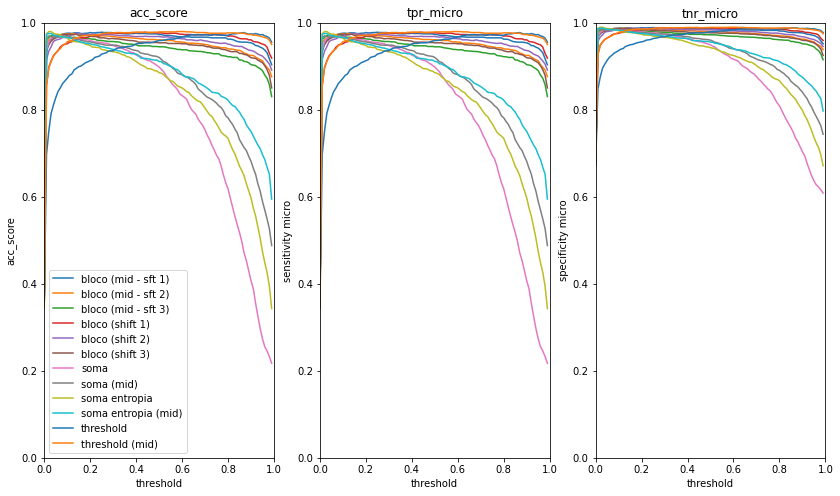

In [6]:
import matplotlib.pyplot as plt

grouped = metrics_df.groupby('metric')

# acc_score
f = plt.figure(figsize=(14, 8))
ax = plt.subplot(1, 3, 1)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='acc_score', label=name)
ax.set_title("acc_score")
ax.set_xlim(0.0, 1.0)
ax.set_ylabel("acc_score")
ax.set_ylim(0.0, 1.0)

ax = plt.subplot(1, 3, 2)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tpr_micro', label=name, legend=False)
ax.set_title("tpr_micro")
ax.set_xlim(0.0, 1.0)
ax.set_ylabel("sensitivity micro")
ax.set_ylim(0.0, 1.0)

ax = plt.subplot(1, 3, 3)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tnr_micro', label=name, legend=False)
ax.set_title("tnr_micro")
ax.set_xlim(0.0, 1.0)
ax.set_ylabel("specificity micro")
ax.set_ylim(0.0, 1.0)
plt.show()


# # plt.gca().set_title(name)
# plt.gca().set_ylim(0.7, 1.0)
# plt.tight_layout()
# plt.show()

# for i, (name, g) in enumerate(grouped):
#     # create subplot axes in a 3x4 grid
#     ax = plt.subplot(3, 4, i + 1) # nrows, ncols, axes position
#     # plot the continent on these axes
#     g.plot(ax=ax, x='threshold', y='acc_score')
#     # set the title
#     ax.set_title(name)
#     ax.set_ylim(0.7, 1.0)
#     # set the aspect
# #     ax.set_aspect('equal', adjustable='datalim')

# plt.tight_layout()
# plt.show()

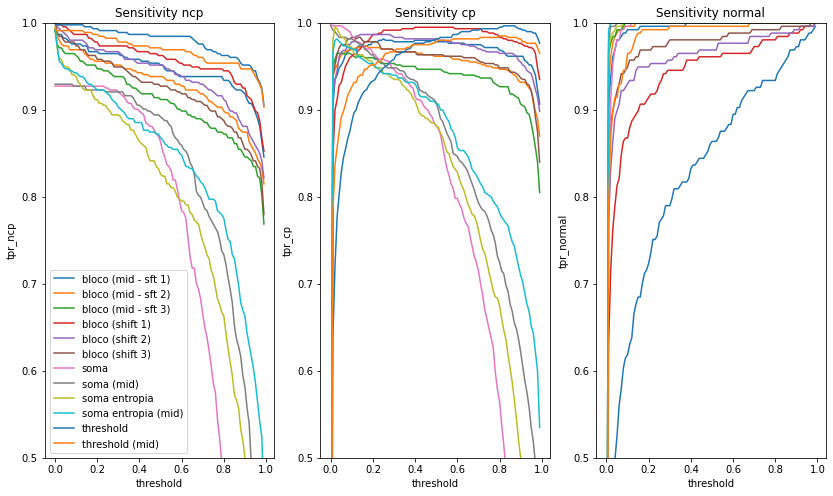

In [7]:
import matplotlib.pyplot as plt

grouped = metrics_df.groupby('metric')

# acc_score
f = plt.figure(figsize=(14, 8))
ax = plt.subplot(1, 3, 1)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tpr_ncp', label=name)
ax.set_title("Sensitivity ncp")
ax.set_ylabel("tpr_ncp")
ax.set_ylim(0.5, 1.0)


ax = plt.subplot(1, 3, 2)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tpr_cp', label=name, legend=False)
ax.set_title("Sensitivity cp")
ax.set_ylabel("tpr_cp")
ax.set_ylim(0.5, 1.0)


ax = plt.subplot(1, 3, 3)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tpr_normal', label=name, legend=False)
ax.set_title("Sensitivity normal")
ax.set_ylabel("tpr_normal")
ax.set_ylim(0.5, 1.0)
plt.show()

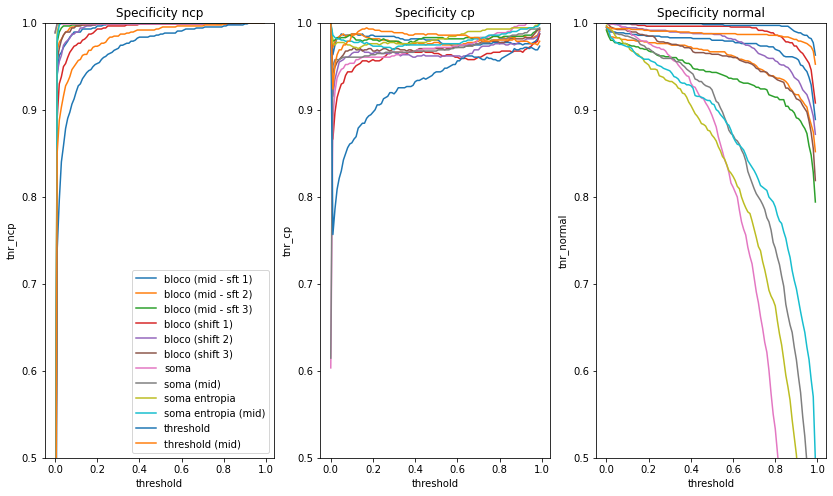

In [8]:
import matplotlib.pyplot as plt

grouped = metrics_df.groupby('metric')

# acc_score
f = plt.figure(figsize=(14, 8))
ax = plt.subplot(1, 3, 1)
# fig, ax = plt.subplots(figsize=(8,6))
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tnr_ncp', label=name)
ax.set_title("Specificity ncp")
ax.set_ylabel("tnr_ncp")
ax.set_ylim(0.5, 1.0)


ax = plt.subplot(1, 3, 2)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tnr_cp', label=name, legend=False)
ax.set_title("Specificity cp")
ax.set_ylabel("tnr_cp")
ax.set_ylim(0.5, 1.0)


ax = plt.subplot(1, 3, 3)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tnr_normal', label=name, legend=False)
ax.set_title("Specificity normal")
ax.set_ylabel("tnr_normal")
ax.set_ylim(0.5, 1.0)
plt.show()

# Roc Curve

In [ ]:
import matplotlib.pyplot as plt


metrics_df['fpr_ncp'] = 1 - metrics_df['tnr_ncp']
metrics_df['fpr_cp'] = 1 - metrics_df['tnr_cp']
metrics_df['fpr_normal'] = 1 - metrics_df['tnr_normal']
metrics_df['fpr_macro'] = 1 - metrics_df['tnr_macro']
metrics_df['fpr_micro'] = 1 - metrics_df['tnr_micro']

grouped = metrics_df.groupby('metric')

# acc_score
f = plt.figure(figsize=(14, 10))

# fig, ax = plt.subplots(figsize=(8,6))
for i, (name, g) in enumerate(grouped, start=1):
    ax = plt.subplot(3, 4, i)
    ncpmx, ncpmy = g['fpr_ncp'].mean(), g['tpr_ncp'].mean()
    cpmx, cpmy = g['fpr_cp'].mean(), g['tpr_cp'].mean()
    normalmx, normalmy = g['fpr_normal'].mean(), g['tpr_normal'].mean()
    g.plot.scatter(ax=ax, x=ncpmx, y=ncpmx, label="NCP", color='blue', s=1)
    g.plot.scatter(ax=ax, x=cpmx, y=cpmx, label="CP", color='orange', s=1)
    g.plot.scatter(ax=ax, x=normalmx, y=normalmx,
                   label="Normal", color='green', s=1)
#     g.plot.scatter(ax = ax, x='fpr_ncp', y='tpr_ncp', label="NCP", color='blue', s=1)
#     g.plot.scatter(ax = ax, x='fpr_cp', y='tpr_cp', label="CP", color='orange', s=1)
#     g.plot.scatter(ax = ax, x='fpr_normal', y='tpr_normal', label="Normal", color='green', s=1)
    ax.set_title(name)
    ax.set_xlim(0.0, 0.25)
    ax.set_ylim(0.75, 1.0)
    if i >= 9:
        ax.set_xlabel("False Positive Rate")
    else:
        ax.set_xlabel("")
    if (i % 4) == 1:
        ax.set_ylabel("True Positive Rate")
    else:
        ax.set_ylabel("")


# ax.set_ylim(0.5, 1.0)


# ax = plt.subplot(1, 3, 2)
# for i, (name, g) in enumerate(grouped):
#     g.plot(ax = ax, x='threshold', y='tnr_cp', label=name, legend=False)
# ax.set_title("Specificity cp")
# ax.set_ylabel("tnr_cp")
# ax.set_ylim(0.5, 1.0)


# ax = plt.subplot(1, 3, 3)
# for i, (name, g) in enumerate(grouped):
#     g.plot(ax = ax, x='threshold', y='tnr_normal', label=name, legend=False)
# ax.set_title("Specificity normal")
# ax.set_ylabel("tnr_normal")
# ax.set_ylim(0.5, 1.0)
# plt.show()

# Score Acuracia

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

results = [('dummy uniforme', dummy_uni_pred),
           ('dummy mais frequente', dummy_most_pred),
           ('dummy dist. entrada', dummy_strat_pred),
           ('heuristica bloco', block_result),
           ('heuristica threshold', threshold_result),
           ('heuristica soma', sum_percent_result),
           ('heuristica soma entropia', small_entropy_result),
           ('heuristica bloco (mid)', block_midllelung_result),
           ('heuristica threshold (mid)', threshold_midllelung_result),
           ('heuristica soma (mid)', sum_percent_midllelung_result),
           ('heuristica soma entropia (mid)', small_entropy_midllelung_result)
           ]

for name, result in results:
    print("acurácia {:<30}= {:0.2f}".format(
        name, accuracy_score(labels, result)))

acurácia dummy uniforme                = 0.31
acurácia dummy mais frequente          = 0.49
acurácia dummy dist. entrada           = 0.38
acurácia heuristica bloco              = 0.49
acurácia heuristica threshold          = 0.93
acurácia heuristica soma               = 0.90
acurácia heuristica soma entropia      = 0.85
acurácia heuristica bloco (mid)        = 0.49
acurácia heuristica threshold (mid)    = 0.96
acurácia heuristica soma (mid)         = 0.92
acurácia heuristica soma entropia (mid)= 0.89


In [22]:
print(classification_report(labels, block_result))

              precision    recall  f1-score   support

          CP       0.00      0.00      0.00       246
         NCP       0.95      0.96      0.96       156
      Normal       0.28      1.00      0.44        97

    accuracy                           0.49       499
   macro avg       0.41      0.65      0.47       499
weighted avg       0.35      0.49      0.38       499



/home/tiagonb/miniconda2/envs/covid/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for name, result in results:
    cnf_matrix1 = confusion_matrix(labels, result)
    cnf_matrix2 = confusion_matrix(
        labels, result, labels=["NCP", "CP", "Normal"])

    print(cnf_matrix1)
    print(cnf_matrix2)

#     print("{:<40}= {:0.2f}".format(name, accuracy_score(labels, result)))

In [28]:
cnf_m = confusion_matrix(labels, results[0][1])

# confusion matrix for three class classification is the sum of columns and rows in the matrix
# rows corresponds to observations 
# columns corresponds to prediction 

# True positives (diagonal matrix)
TP = np.diag(cnf_m) 
# False positives corresponds to the sum os values in the column i minus value of diagonal i
FP = cnf_m.sum(axis=0) - TP
# False negatives corresponds to the sum os values in the row i minus value of diagonal i
FN = cnf_m.sum(axis=1) - TP


print(cnf_m)
cnf_m.sum(axis=1)

[[76 81 89]
 [57 56 43]
 [37 34 26]]


array([246, 156,  97])

In [32]:
cnf_matrix = confusion_matrix(labels, results[0][1])

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

# print("Sensitivity={:0.2f}, Specificity={:0.2f}, Accuracy={:0.2f}".format(TPR, TNR, ACC))
print(TPR, TNR, ACC)

[0.30894309 0.35897436 0.26804124] [0.6284585  0.66472303 0.67164179] [0.47094188 0.56913828 0.59318637]


In [15]:
from sklearn.metrics import recall_score

recall_score(labels, results[0][1], average='weighted')

0.312625250501002

In [12]:
print(classification_report(labels, results[0][1]))

              precision    recall  f1-score   support

          CP       0.46      0.28      0.35       246
         NCP       0.30      0.32      0.31       156
      Normal       0.20      0.38      0.26        97

    accuracy                           0.31       499
   macro avg       0.32      0.33      0.31       499
weighted avg       0.36      0.31      0.32       499



In [23]:
cnf_matrix2 = multilabel_confusion_matrix(
    labels, results[0][1], labels=['NCP', 'CP', 'Normal'])

print(cnf_matrix2.ravel())

[227 116 106  50 173  80 177  69 255 147  60  37]


In [25]:
from sklearn.metrics import multilabel_confusion_matrix

cnf_matrix2 = multilabel_confusion_matrix(
    labels, results[0][1], labels=['NCP', 'CP', 'Normal'])

tn_ncp, fp_ncp, fn_ncp, tp_ncp = cnf_matrix2[0].ravel()
tn_cp, fp_cp, fn_cp, tp_cp = cnf_matrix2[1].ravel()
tn_normal, fp_normal, fn_normal, tp_normal = cnf_matrix2[2].ravel()
print("tn={:0.2f},fp={:0.2f},fn={:0.2f},tp={:0.2f}".format(
    tn_ncp, fp_ncp, fn_ncp, tp_ncp))
print("tn={:0.2f},fp={:0.2f},fn={:0.2f},tp={:0.2f}".format(
    tn_cp, fp_cp, fn_cp, tp_cp))
print("tn={:0.2f},fp={:0.2f},fn={:0.2f},tp={:0.2f}".format(
    tn_normal, fp_normal, fn_normal, tp_normal))

# tn, fp, fn, tp = cnf_matrix2[0].ravel()
for m in cnf_matrix2:
    tn, fp, fn, tp = m.ravel()
    print("tn={:0.2f},fp={:0.2f},fn={:0.2f},tp={:0.2f}".format(tn, fp, fn, tp))
    print("sum={:0.2f}".format(tn + fp + fn + tp))
    # Sensitivity, hit rate, recall, or true positive rate
    tpr = tp/(tp+fn)
    # Specificity or true negative rate
    tnr = tn/(tn+fp)
    # Overall accuracy for each class in binary classification (TP + TN) / (TP + TN + FP + FN)
    # for multi class case, remove tn to be equal score_accuracy
    acc = (tp)/(tp+fp+fn+tn)
    print("Sensitivity={:0.2f}, Specificity={:0.2f}, Accuracy={:0.2f}".format(
        tpr, tnr, acc))

tn=227.00,fp=116.00,fn=106.00,tp=50.00
tn=173.00,fp=80.00,fn=177.00,tp=69.00
tn=255.00,fp=147.00,fn=60.00,tp=37.00
tn=227.00,fp=116.00,fn=106.00,tp=50.00
sum=499.00
Sensitivity=0.32, Specificity=0.66, Accuracy=0.10
tn=173.00,fp=80.00,fn=177.00,tp=69.00
sum=499.00
Sensitivity=0.28, Specificity=0.68, Accuracy=0.14
tn=255.00,fp=147.00,fn=60.00,tp=37.00
sum=499.00
Sensitivity=0.38, Specificity=0.63, Accuracy=0.07


# Histogramas

/home/tiagonb/miniconda2/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<AxesSubplot:title={'center':"('test', 'CP')"}>,
        <AxesSubplot:title={'center':"('test', 'NCP')"}>,
        <AxesSubplot:title={'center':"('test', 'Normal')"}>],
       [<AxesSubplot:title={'center':"('train', 'CP')"}>,
        <AxesSubplot:title={'center':"('train', 'NCP')"}>,
        <AxesSubplot:title={'center':"('train', 'Normal')"}>],
       [<AxesSubplot:title={'center':"('val', 'CP')"}>,
        <AxesSubplot:title={'center':"('val', 'NCP')"}>,
        <AxesSubplot:title={'center':"('val', 'Normal')"}>]], dtype=object)

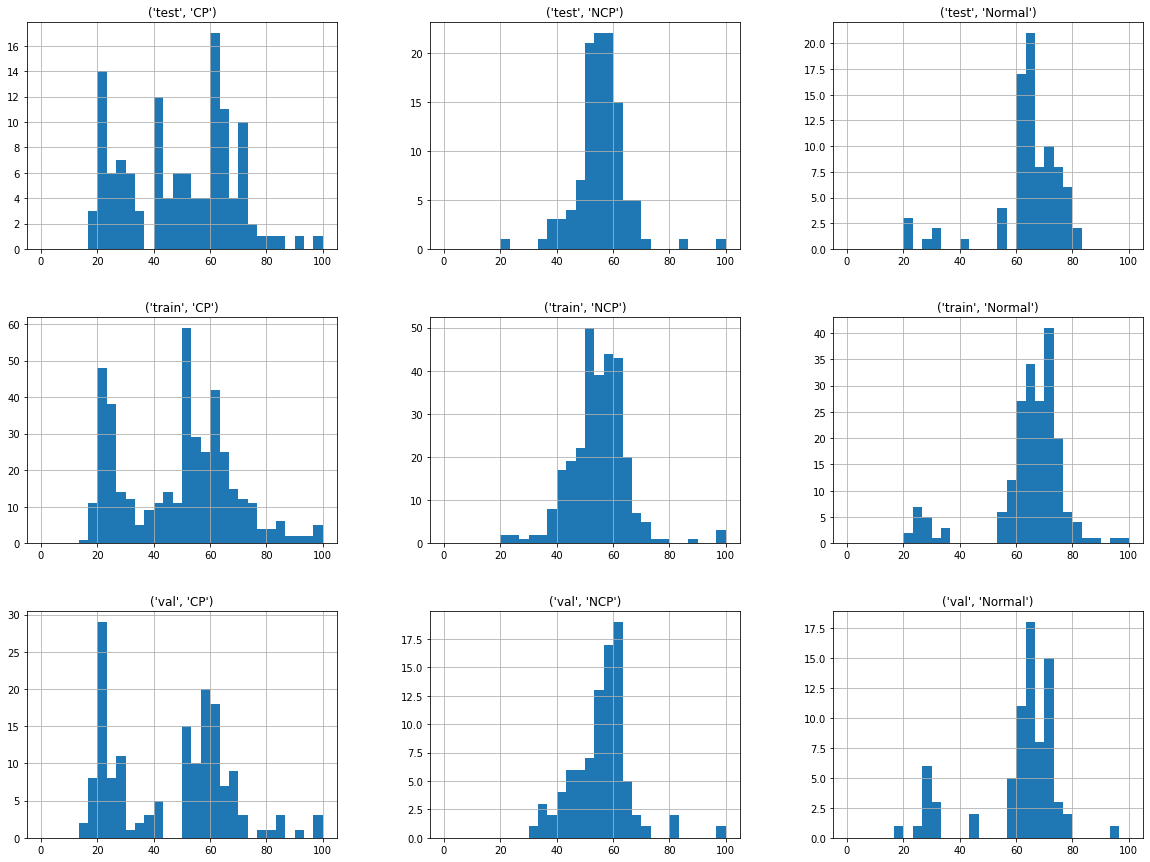

In [27]:
# new_df['dataset'].value_counts()

dd = new_df.groupby(['split_class', 'label', 'dataset'])['label'].count()
fig = plt.figure(figsize=(20, 15))
ax = fig.gca()
ddd = dd.unstack(level=0)
dddd = ddd.unstack(level=0)
dddd.hist(bins=30, ax=ax, range=[0, 100])

# Scratch

In [22]:
from sklearn.dummy import DummyClassifier

# classificador dummy uniforme
dummy_uni = DummyClassifier(strategy="uniform")
dummy_uni.fit(labels, labels)
dummy_pred = dummy_uni.predict(labels)
c = Counter(dummy_pred)
print(c)
print("Acurácia (dummy uniforme): {:0.2f}".format(
    accuracy_score(labels, dummy_pred)))

# classificador dummy mais frequente
dummy_most = DummyClassifier(strategy="most_frequent")
dummy_most.fit(labels, labels)
dummy_pred = dummy_most.predict(labels)
c = Counter(dummy_pred)
print(c)
print("Acurácia (dummy mais frequente): {:0.2f}".format(
    accuracy_score(labels, dummy_pred)))

# classificador dummy distribuição de entrada
dummy_strat = DummyClassifier(strategy="stratified")
dummy_strat.fit(labels, labels)
dummy_pred = dummy_strat.predict(labels)
c = Counter(dummy_pred)
print(c)
print("Acurácia (dummy distribuição da entrada): {:0.2f}".format(
    accuracy_score(labels, dummy_pred)))

Counter({'NCP': 171, 'Normal': 168, 'CP': 160})
Acurácia (dummy uniforme): 0.35
Counter({'CP': 499})
Acurácia (dummy mais frequente): 0.49
Counter({'CP': 241, 'NCP': 155, 'Normal': 103})
Acurácia (dummy distribuição da entrada): 0.39


In [16]:
from collections import Counter

c = Counter(labels)
c

Counter({'CP': 195, 'NCP': 184, 'Normal': 104})

n=3, cols=12, rows=1


/home/tiagonb/miniconda2/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:133: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/tiagonb/miniconda2/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:134: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2 0 4
3 0 6
4 0 8


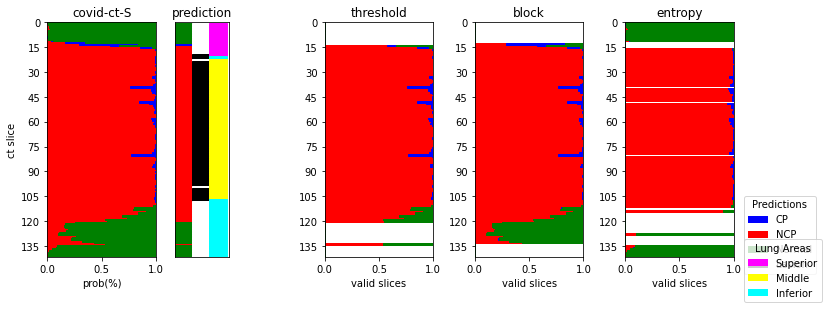

In [60]:
m1 = metric_valid_threshold(new_df)
m2 = metric_valid_block(new_df)
m3 = metric_valid_entropy(new_df)
# print(m3)
make_panel_with_metrics(df, [(m1, 'threshold'), (m2, 'block'), (m3, 'entropy')],
                        figtitle=None, savefig=None, model_shortname=model_shortname)

n=6, cols=12, rows=2


/home/tiagonb/miniconda2/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:104: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/tiagonb/miniconda2/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


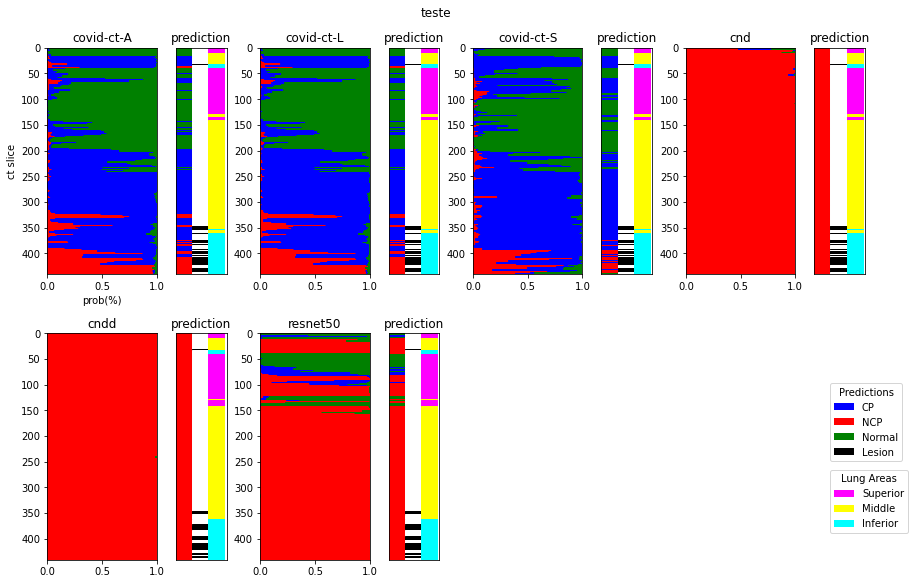

In [1]:
from sklearn.metrics import roc_auc_score
from scipy import interp
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
print(__doc__)


# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thold = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thold[i] = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Automatically created module for IPython interactive environment
